In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt



2022-05-15 20:12:39.879918: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-15 20:12:39.879968: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
datasets = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test,
                               y_test) = keras.datasets.fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]



In [3]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


In [4]:
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train))
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))


2022-05-15 20:12:43.332775: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-15 20:12:43.332909: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-15 20:12:43.332932: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-GC2VT9N): /proc/driver/nvidia/version does not exist
2022-05-15 20:12:43.333270: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:

def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    return tf.train.Example(
        features=tf.train.Features(
          feature={
            "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_data.numpy()])),
            "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
          }
        )
    )


In [6]:
for image, label in valid_set.take(1):
    print(create_example(image, label))


features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\rI\000\000\001\004\000\000\000\000\001\001\000\000\000\000\000\000\000\000\000\000\000\000\000\003\000$\210\177>6\000\000\000\001\003\004\000\000\003\000\000\000\000\000\000\000\000\000\000\000\000\006\000f\314\260\206\220{\027\000\000\000\000\014\n\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\233\354\317\262k\234\241m@\027M\202H\017\000\000\000\000\000\000\000\000\000\000\000\001\000E\317\337\332\330\330\243\177yz\222\215X\254B\000\000\00

In [7]:
from contextlib import ExitStack

def write_tfrecords(name, dataset, n_shards=10):
    paths = ["{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards)
             for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                   for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return paths


In [8]:
train_filepaths = write_tfrecords("my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", valid_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_set)


# B

In [10]:
def preprocess(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    #image = tf.io.decode_jpeg(example["image"])
    image = tf.reshape(image, shape=[28, 28])
    return image, example["label"]


def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None,
                  n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)


In [11]:
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)


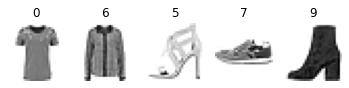

In [12]:
for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))


In [17]:
# tf.keras.layers.Normalization(
#     axis=-1, mean=None, variance=None, invert=False, **kwargs
# )
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


# class Standardization(keras.layers.Layer):
#     def adapt(self, data_sample):
#         self.means_ = np.mean(data_sample, axis=0, keepdims=True)
#         self.stds_ = np.std(data_sample, axis=0, keepdims=True)

#     def call(self, inputs):
#         return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())


# standardization = Standardization(input_shape=[28, 28])
standardization = keras.layers.Normalization(input_shape=[28, 28])
sample_image_batches = train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()),
                               axis=0).astype(np.float32)

standardization.adapt(sample_images)

model = keras.models.Sequential([
    standardization,
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])


In [18]:
import os
from datetime import datetime
logs = os.path.join(os.curdir, "my_logs",
                    "run_" + datetime.now().strftime("%Y%m%d_%H%M%S"))

tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=logs, histogram_freq=1, profile_batch=10)

model.fit(train_set, epochs=5, validation_data=valid_set,
          callbacks=[tensorboard_cb])


Epoch 1/5


2022-05-15 20:16:27.883800: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-05-15 20:16:27.883883: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-05-15 20:16:27.884809: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.


     41/Unknown - 1s 6ms/step - loss: 1.0508 - accuracy: 0.6288

2022-05-15 20:16:28.633918: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-05-15 20:16:28.633991: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-05-15 20:16:28.641000: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2022-05-15 20:16:28.646278: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2022-05-15 20:16:28.655439: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./my_logs/run_20220515_201627/plugins/profile/2022_05_15_20_16_28

2022-05-15 20:16:28.659001: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./my_logs/run_20220515_201627/plugins/profile/2022_05_15_20_16_28/DESKTOP-GC2VT9N.trace.json.gz
2022-05-15 20:16:28.666398: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./my_logs/run_20220515_201627/plugin

1719/1719 [==============================] - 10s 6ms/step - loss: 0.4440 - accuracy: 0.8399 - val_loss: 0.3675 - val_accuracy: 0.8712
Epoch 2/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3320 - accuracy: 0.8800 - val_loss: 0.3517 - val_accuracy: 0.8756
Epoch 3/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2950 - accuracy: 0.8913 - val_loss: 0.3324 - val_accuracy: 0.8856
Epoch 4/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2688 - accuracy: 0.9001 - val_loss: 0.3293 - val_accuracy: 0.8848
Epoch 5/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2519 - accuracy: 0.9071 - val_loss: 0.3348 - val_accuracy: 0.8862


In [19]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

In [20]:
from pathlib import Path

DOWNLOAD_ROOT = "http://ai.stanford.edu/~amaas/data/sentiment/"
FILENAME = "aclImdb_v1.tar.gz"
filepath = keras.utils.get_file(
    FILENAME, DOWNLOAD_ROOT + FILENAME, extract=True)
path = Path(filepath).parent / "aclImdb"
path


84140032/84125825 [==============================] - 15s 0us/step


PosixPath('/home/tatsuyafukui/.keras/datasets/aclImdb')

In [21]:
for name, subdirs, files in os.walk(path):
    indent = len(Path(name).parts) - len(path.parts)
    print("    " * indent + Path(name).parts[-1] + os.sep)
    for index, filename in enumerate(sorted(files)):
        if index == 3:
            print("    " * (indent + 1) + "...")
            break
        print("    " * (indent + 1) + filename)


aclImdb/
    README
    imdb.vocab
    imdbEr.txt
    test/
        labeledBow.feat
        urls_neg.txt
        urls_pos.txt
        neg/
            0_2.txt
            10000_4.txt
            10001_1.txt
            ...
        pos/
            0_10.txt
            10000_7.txt
            10001_9.txt
            ...
    train/
        labeledBow.feat
        unsupBow.feat
        urls_neg.txt
        ...
        neg/
            0_3.txt
            10000_4.txt
            10001_4.txt
            ...
        pos/
            0_9.txt
            10000_8.txt
            10001_10.txt
            ...
        unsup/
            0_0.txt
            10000_0.txt
            10001_0.txt
            ...


In [22]:
def review_paths(dirpath):
    return [str(path) for path in dirpath.glob("*.txt")]


train_pos = review_paths(path / "train" / "pos")
train_neg = review_paths(path / "train" / "neg")
test_valid_pos = review_paths(path / "test" / "pos")
test_valid_neg = review_paths(path / "test" / "neg")

len(train_pos), len(train_neg), len(test_valid_pos), len(test_valid_neg)


(12500, 12500, 12500, 12500)

In [23]:
np.random.shuffle(test_valid_pos)

test_pos = test_valid_pos[:5000]
test_neg = test_valid_neg[:5000]
valid_pos = test_valid_pos[5000:]
valid_neg = test_valid_neg[5000:]


In [24]:
def imdb_dataset(filepaths_positive, filepaths_negative):
    reviews = []
    labels = []
    for filepaths, label in ((filepaths_negative, 0), (filepaths_positive, 1)):
        for filepath in filepaths:
            with open(filepath) as review_file:
                reviews.append(review_file.read())
            labels.append(label)
    return tf.data.Dataset.from_tensor_slices(
        (tf.constant(reviews), tf.constant(labels)))


In [25]:
for X, y in imdb_dataset(train_pos, train_neg).take(3):
    print(X)
    print(y)
    print()


tf.Tensor(b"Can I please say first of all, that I felt so strongly about this movie that I signed up to IMDb specifically to review it. And my review? This is easily the worst movie I have ever seen.<br /><br />The synopsis of the movie sounded interesting- Nazis, occult, time travel, etc., but the movies plot failed to properly bring all these elements together. Remember the episode of South Park that featured manatees writing Family Guy using 'idea balls'? Did these manatees also write Unholy? Its like the writer wanted to include all these different ideas, but had no idea how to link them all together, and then to make things make even less sense, included a Donnie Darko-esquire time travel theme to the ending, messing up the chronology.<br /><br />I could tell from early on that this was a bad movie. Special effects were too low budget for anything better than straight to DVD. The acting wasn't great, but in fairness I've seen worse. I will praise the Nazi paintings, they were cree

In [26]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).repeat(10): pass

25.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [27]:
def imdb_dataset(filepaths_positive, filepaths_negative, n_read_threads=5):
    dataset_neg = tf.data.TextLineDataset(filepaths_negative,
                                          num_parallel_reads=n_read_threads)
    dataset_neg = dataset_neg.map(lambda review: (review, 0))
    dataset_pos = tf.data.TextLineDataset(filepaths_positive,
                                          num_parallel_reads=n_read_threads)
    dataset_pos = dataset_pos.map(lambda review: (review, 1))
    return tf.data.Dataset.concatenate(dataset_pos, dataset_neg)


In [28]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).cache().repeat(10): pass

26.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [29]:
batch_size = 32

train_set = imdb_dataset(train_pos, train_neg).shuffle(
    25000).batch(batch_size).prefetch(1)
valid_set = imdb_dataset(valid_pos, valid_neg).batch(batch_size).prefetch(1)
test_set = imdb_dataset(test_pos, test_neg).batch(batch_size).prefetch(1)


In [30]:
def preprocess(X_batch, n_words=50):
    shape = tf.shape(X_batch) * tf.constant([1, 0]) + tf.constant([0, n_words])
    Z = tf.strings.substr(X_batch, 0, 300)
    Z = tf.strings.lower(Z)
    Z = tf.strings.regex_replace(Z, b"<br\\s*/?>", b" ")
    Z = tf.strings.regex_replace(Z, b"[^a-z]", b" ")
    Z = tf.strings.split(Z)
    return Z.to_tensor(shape=shape, default_value=b"<pad>")


X_example = tf.constant(
    ["It's a great, great movie! I loved it.", "It was terrible, run away!!!"])
preprocess(X_example)


<tf.Tensor: shape=(2, 50), dtype=string, numpy=
array([[b'it', b's', b'a', b'great', b'great', b'movie', b'i', b'loved',
        b'it', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>'],
       [b'it', b'was', b'terrible', b'run', b'away', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'

In [31]:
from collections import Counter


def get_vocabulary(data_sample, max_size=1000):
    preprocessed_reviews = preprocess(data_sample).numpy()
    counter = Counter()
    for words in preprocessed_reviews:
        for word in words:
            if word != b"<pad>":
                counter[word] += 1
    return [b"<pad>"] + [word for word, count in counter.most_common(max_size)]


get_vocabulary(X_example)


[b'<pad>',
 b'it',
 b'great',
 b's',
 b'a',
 b'movie',
 b'i',
 b'loved',
 b'was',
 b'terrible',
 b'run',
 b'away']

In [32]:
class TextVectorization(keras.layers.Layer):
    def __init__(self, max_vocabulary_size=1000, n_oov_buckets=100, dtype=tf.string, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.max_vocabulary_size = max_vocabulary_size
        self.n_oov_buckets = n_oov_buckets

    def adapt(self, data_sample):
        self.vocab = get_vocabulary(data_sample, self.max_vocabulary_size)
        words = tf.constant(self.vocab)
        word_ids = tf.range(len(self.vocab), dtype=tf.int64)
        vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
        self.table = tf.lookup.StaticVocabularyTable(
            vocab_init, self.n_oov_buckets)

    def call(self, inputs):
        preprocessed_inputs = preprocess(inputs)
        return self.table.lookup(preprocessed_inputs)


In [35]:
text_vectorization = TextVectorization()

text_vectorization.adapt(X_example)
text_vectorization(X_example)



<tf.Tensor: shape=(2, 50), dtype=int64, numpy=
array([[ 1,  3,  4,  2,  2,  5,  6,  7,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 1,  8,  9, 10, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]])>

In [37]:
max_vocabulary_size = 1000
n_oov_buckets = 100

sample_review_batches = train_set.map(lambda review, _: review)
sample_reviews = np.concatenate(list(sample_review_batches.as_numpy_iterator()),
                                axis=0)

text_vectorization = TextVectorization(max_vocabulary_size, n_oov_buckets,
                                       input_shape=[])
text_vectorization.adapt(sample_reviews)


In [38]:
text_vectorization(X_example)


<tf.Tensor: shape=(2, 50), dtype=int64, numpy=
array([[  9,  14,   2,  64,  64,  12,   5, 257,   9,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  9,  13, 269, 530, 334,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>

In [39]:
text_vectorization.vocab[:10]


[b'<pad>', b'the', b'a', b'of', b'and', b'i', b'to', b'is', b'this', b'it']

In [40]:
simple_example = tf.constant([[1, 3, 1, 0, 0], [2, 2, 0, 0, 0]])
tf.reduce_sum(tf.one_hot(simple_example, 4), axis=1)


<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[2., 2., 0., 1.],
       [3., 0., 2., 0.]], dtype=float32)>

In [41]:
class BagOfWords(keras.layers.Layer):
    def __init__(self, n_tokens, dtype=tf.int32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.n_tokens = n_tokens

    def call(self, inputs):
        one_hot = tf.one_hot(inputs, self.n_tokens)
        return tf.reduce_sum(one_hot, axis=1)[:, 1:]


In [42]:
bag_of_words = BagOfWords(n_tokens=4)
bag_of_words(simple_example)


<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[2., 0., 1.],
       [0., 2., 0.]], dtype=float32)>

In [43]:
n_tokens = max_vocabulary_size + n_oov_buckets + 1  # add 1 for <pad>
bag_of_words = BagOfWords(n_tokens)


In [44]:
model = keras.models.Sequential([
    text_vectorization,
    bag_of_words,
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)


Epoch 1/5
782/782 [==============================] - 12s 11ms/step - loss: 0.5435 - accuracy: 0.7176 - val_loss: 0.5098 - val_accuracy: 0.7404
Epoch 2/5
782/782 [==============================] - 13s 13ms/step - loss: 0.4731 - accuracy: 0.7682 - val_loss: 0.5046 - val_accuracy: 0.7468
Epoch 3/5
782/782 [==============================] - 13s 13ms/step - loss: 0.4239 - accuracy: 0.8040 - val_loss: 0.5086 - val_accuracy: 0.7462
Epoch 4/5
782/782 [==============================] - 13s 13ms/step - loss: 0.3543 - accuracy: 0.8506 - val_loss: 0.5402 - val_accuracy: 0.7371
Epoch 5/5
782/782 [==============================] - 13s 13ms/step - loss: 0.2728 - accuracy: 0.8980 - val_loss: 0.5922 - val_accuracy: 0.7225


In [45]:
def compute_mean_embedding(inputs):
    not_pad = tf.math.count_nonzero(inputs, axis=-1)
    n_words = tf.math.count_nonzero(not_pad, axis=-1, keepdims=True)
    sqrt_n_words = tf.math.sqrt(tf.cast(n_words, tf.float32))
    return tf.reduce_sum(inputs, axis=1) / sqrt_n_words


another_example = tf.constant([[[1., 2., 3.], [4., 5., 0.], [0., 0., 0.]],
                               [[6., 0., 0.], [0., 0., 0.], [0., 0., 0.]]])
compute_mean_embedding(another_example)


<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[3.535534 , 4.9497476, 2.1213205],
       [6.       , 0.       , 0.       ]], dtype=float32)>

In [46]:
tf.reduce_mean(another_example[0:1, :2], axis=1) * tf.sqrt(2.)


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[3.535534 , 4.9497476, 2.1213202]], dtype=float32)>

In [47]:
tf.reduce_mean(another_example[1:2, :1], axis=1) * tf.sqrt(1.)


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[6., 0., 0.]], dtype=float32)>

In [48]:
embedding_size = 20

model = keras.models.Sequential([
    text_vectorization,
    keras.layers.Embedding(input_dim=n_tokens,
                           output_dim=embedding_size,
                           mask_zero=True),  # <pad> tokens => zero vectors
    keras.layers.Lambda(compute_mean_embedding),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
])


In [49]:
model.compile(loss="binary_crossentropy",
              optimizer="nadam", metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)


Epoch 1/5
782/782 [==============================] - 8s 6ms/step - loss: 0.5547 - accuracy: 0.7075 - val_loss: 0.5137 - val_accuracy: 0.7426
Epoch 2/5
782/782 [==============================] - 8s 8ms/step - loss: 0.4968 - accuracy: 0.7536 - val_loss: 0.5127 - val_accuracy: 0.7404
Epoch 3/5
782/782 [==============================] - 10s 9ms/step - loss: 0.4873 - accuracy: 0.7599 - val_loss: 0.5070 - val_accuracy: 0.7422
Epoch 4/5
782/782 [==============================] - 10s 10ms/step - loss: 0.4800 - accuracy: 0.7632 - val_loss: 0.5025 - val_accuracy: 0.7422
Epoch 5/5
782/782 [==============================] - 12s 11ms/step - loss: 0.4731 - accuracy: 0.7649 - val_loss: 0.5040 - val_accuracy: 0.7413


In [51]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="imdb_reviews")
train_set, test_set = datasets["train"], datasets["test"]


2022-05-15 22:29:22.788194: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /home/tatsuyafukui/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEEOZ91/imdb_reviews-t…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /home/tatsuyafukui/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEEOZ91/imdb_reviews-t…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /home/tatsuyafukui/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEEOZ91/imdb_reviews-u…

Dataset imdb_reviews downloaded and prepared to /home/tatsuyafukui/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [52]:
for example in train_set.take(1):
    print(example["text"])
    print(example["label"])


tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


2022-05-15 22:30:09.824931: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
